<a href="https://colab.research.google.com/github/JonFillip/plant_phenotyping_model/blob/main/plant_phenotype_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
import glob
import json
import random
import warnings
from tensorflow import keras
from matplotlib.lines import Line2D
from google.colab.patches import cv2_imshow
from google.colab import drive, files
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/My Drive/Colab Notebooks/plant_phenotyping_rgbd/"   

def fetch_phenotype_data(path=PATH):
  if os.path.exists(PATH):
    print('directory already exists')
  else:
    os.makedirs(PATH)
    upload = files.upload()

  # change directory to 'grape'
  %cd /content/drive/My Drive/Colab Notebooks/plant_phenotyping_rgbd/


fetch_phenotype_data()

directory already exists
/content/drive/My Drive/Colab Notebooks/plant_phenotyping_rgbd


In [ ]:
from pathlib import Path

def load_images(image_path, depth_path, image_ext='*.tiff', depth_ext='*.tiff'):
    image_path_obj = Path(image_path)
    depth_path_obj = Path(depth_path)

    # Load RGB images
    rgb_images = []
    for img_path in sorted(image_path_obj.glob(image_ext)):
        try:
            rgb_images.append(cv2.imread(str(img_path), cv2.IMREAD_COLOR))
        except Exception as e:
            print(f"Error loading RGB image at {img_path}: {e}")

    # Load depth images
    depth_images = []
    for img_path in sorted(depth_path_obj.glob(depth_ext)):
        try:
            depth_images.append(cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE))
        except Exception as e:
            print(f"Error loading depth image at {img_path}: {e}")

    return rgb_images, depth_images

In [ ]:
tomato_img_path = PATH+'plant_datasets/tomato_rgbd_dataset/RGB'
tomato_depth_path = PATH+'plant_datasets/tomato_rgbd_dataset/Depth'
lettuce_img_path = PATH+'plant_datasets/lettuce_rgbd_dataset/RGBImages'
lettuce_depth_path = PATH+'plant_datasets/lettuce_rgbd_dataset/DepthImages'

tomato_rgb_images, tomato_depth_images = load_images(tomato_img_path, tomato_depth_path)
lettuce_rgb_images, lettuce_depth_images = load_images(lettuce_img_path, lettuce_depth_path, image_ext='*.png', depth_ext='*.png')

In [ ]:
len(tomato_rgb_images)

123

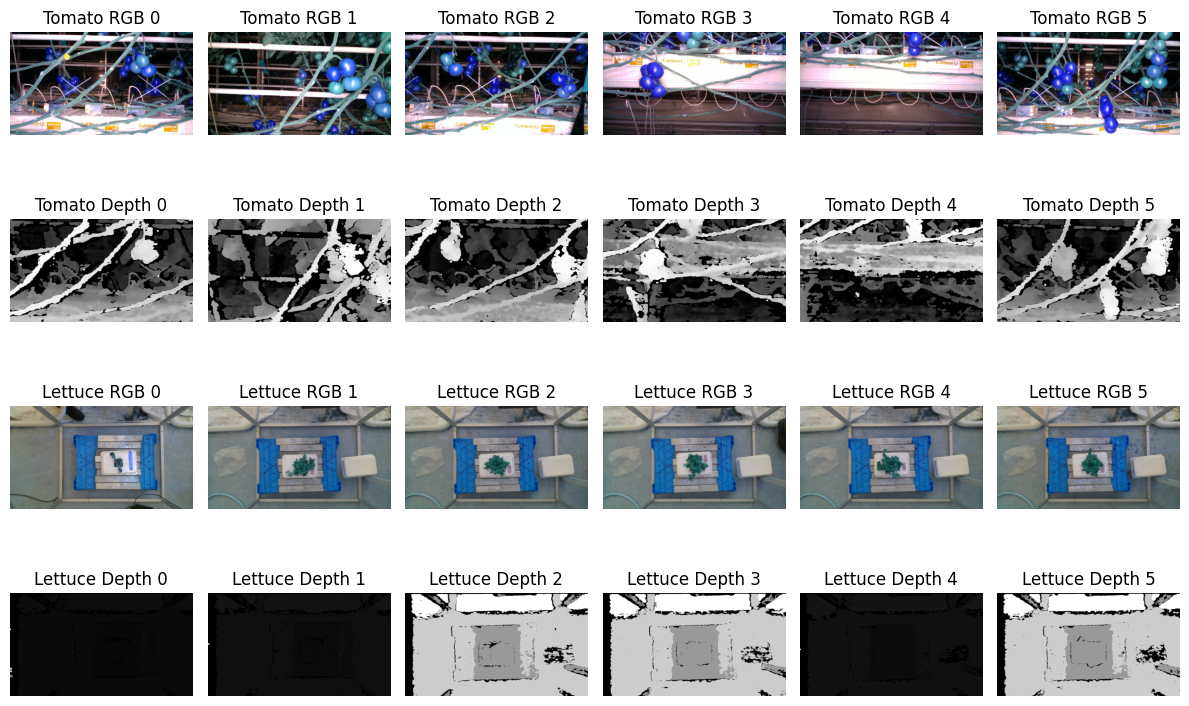

In [ ]:
def display_images(axs, rgb_images, depth_images, title_prefix):
    num_images = min(len(rgb_images), len(depth_images), axs.shape[1])
    for i, (rgb_img, depth_img) in enumerate(zip(rgb_images[:num_images], depth_images[:num_images])):
        axs[0, i].imshow(rgb_img)
        axs[0, i].axis('off')
        axs[0, i].set_title(f"{title_prefix} RGB {i}")

        axs[1, i].imshow(depth_img, cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title(f"{title_prefix} Depth {i}")

fig, axs = plt.subplots(4, 6, figsize=(12, 8))
display_images(axs[:2], tomato_rgb_images, tomato_depth_images, "Tomato")
display_images(axs[2:], lettuce_rgb_images, lettuce_depth_images, "Lettuce")
plt.tight_layout()
plt.show()

In [ ]:
def parse_tomato_groundtruth(file_path):
    with open(file_path) as f:
        data = json.load(f)
    
    # extract image data
    images = pd.DataFrame(data['images'])
    images = images.rename(columns={'id': 'image_id'})
    
    # extract annotation data
    annotations = pd.DataFrame(data['annotations'])
    annotations = annotations.rename(columns={'id': 'annotation_id'})
    
    # extract category data
    categories = pd.DataFrame(data['categories'])
    categories = categories.rename(columns={'id': 'category_id', 'name': 'category_name'})
    
    # merge image and annotation data
    image_annotations = pd.merge(images, annotations, on='image_id')
    
    # merge image_annotation and category data
    df = pd.merge(image_annotations, categories, on='category_id')
    
    return df


In [ ]:
tomato_annotations = ['plant_datasets/tomato_rgbd_dataset/val_2class.JSON', 'plant_datasets/tomato_rgbd_dataset/train_2class.JSON']
dfs = [parse_tomato_groundtruth(PATH+file_path) for file_path in tomato_annotations]
tomatoes_annotation = pd.concat(dfs, ignore_index=True)

In [ ]:
tomatoes_annotation.head(10)

,image_id,width,height,file_name,annotation_id,category_id,segmentation,area,bbox,iscrowd,category_name,supercategory
0,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,1,1,"[236.323, 339.387, 217.774, 357.129, 211.323, ...",8951.61,"[211.3226, 334.5484, 100, 89.51613]",0,redtomato,none
1,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,15,1,"[77.824, 611.715, 97.908, 614.644, 111.715, 63...",8520.86,"[13.80753, 611.7155, 97.90795, 87.02929]",0,redtomato,none
2,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,16,1,"[17.155, 718.41, 24.686, 702.092, 27.615, 690....",1320.00,"[0.41841, 669.8745, 27.19665, 48.53556]",0,redtomato,none
3,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,17,1,"[18.41, 564.854, 1.674, 569.038, 0.837, 653.13...",6866.13,"[0.8368201, 564.8536, 77.40586, 88.70293]",0,redtomato,none
4,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,18,1,"[973.669, 203.129, 971.367, 217.66, 964.688, 2...",8844.95,"[879.6214, 156.1052, 94.04761, 94.04761]",0,redtomato,none
5,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,19,1,"[924.8, 245.871, 922.68, 259.256, 916.527, 271...",7505.20,"[838.1676, 202.5547, 86.63257, 86.63257]",0,redtomato,none
6,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,20,1,"[967.774, 234.581, 987.129, 225.71, 1005.677, ...",9833.51,"[916.9677, 225.7097, 108.871, 90.32258]",0,redtomato,none
7,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,21,1,"[929.871, 159.581, 918.581, 151.516, 908.097, ...",3080.12,"[870.1935, 146.6774, 59.67742, 51.6129]",0,redtomato,none
8,2,1280,720,RealSense_T20190528_230009_R02_P002860_H2300_A...,22,1,"[1277, 503, 1279, 533, 1279, 587, 1258, 594, 1...",11110.00,"[1169, 493, 110, 101]",0,redtomato,none
9,2,1280,720,RealSense_T20190528_230009_R02_P002860_H2300_A...,23,1,"[1237, 407, 1248, 427, 1251, 450, 1247, 478, 1...",14396.00,"[1133, 378, 118, 122]",0,redtomato,none


In [ ]:
# update values in category_name column
tomatoes_annotation['category_name'] = tomatoes_annotation['category_name'].replace({'redtomato': 'ripe tomato', 'greentomato': 'unripe tomato'})

# add fruit_color column and update values
tomatoes_annotation['fruit_color'] = ''
tomatoes_annotation.loc[tomatoes_annotation['category_name'] == 'unripe tomato', 'fruit_color'] = 'green'
tomatoes_annotation.loc[tomatoes_annotation['category_name'] == 'ripe tomato', 'fruit_color'] = 'red'
cols = tomatoes_annotation.columns.tolist()
cols.insert(-1, cols.pop(cols.index('fruit_color')))
tomatoes_annotation = tomatoes_annotation.reindex(columns=cols)

# Update values in supercategory column to all be 'cherry tomato'
tomatoes_annotation['supercategory'] = 'cherry tomato'
tomatoes_annotation = tomatoes_annotation.rename(columns={'category_name': 'fruit_ripeness', 'supercategory': 'super_category'})
tomatoes_annotation.head(10)

,image_id,width,height,file_name,annotation_id,category_id,segmentation,area,bbox,iscrowd,fruit_ripeness,fruit_color,super_category
0,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,1,1,"[236.323, 339.387, 217.774, 357.129, 211.323, ...",8951.61,"[211.3226, 334.5484, 100, 89.51613]",0,ripe tomato,red,cherry tomato
1,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,15,1,"[77.824, 611.715, 97.908, 614.644, 111.715, 63...",8520.86,"[13.80753, 611.7155, 97.90795, 87.02929]",0,ripe tomato,red,cherry tomato
2,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,16,1,"[17.155, 718.41, 24.686, 702.092, 27.615, 690....",1320.00,"[0.41841, 669.8745, 27.19665, 48.53556]",0,ripe tomato,red,cherry tomato
3,0,1280,720,RealSense_T20190528_234546_R04_P026480_H2300_A...,17,1,"[18.41, 564.854, 1.674, 569.038, 0.837, 653.13...",6866.13,"[0.8368201, 564.8536, 77.40586, 88.70293]",0,ripe tomato,red,cherry tomato
4,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,18,1,"[973.669, 203.129, 971.367, 217.66, 964.688, 2...",8844.95,"[879.6214, 156.1052, 94.04761, 94.04761]",0,ripe tomato,red,cherry tomato
5,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,19,1,"[924.8, 245.871, 922.68, 259.256, 916.527, 271...",7505.20,"[838.1676, 202.5547, 86.63257, 86.63257]",0,ripe tomato,red,cherry tomato
6,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,20,1,"[967.774, 234.581, 987.129, 225.71, 1005.677, ...",9833.51,"[916.9677, 225.7097, 108.871, 90.32258]",0,ripe tomato,red,cherry tomato
7,1,1280,720,RealSense_T20190528_230009_R02_P002860_H1630_A...,21,1,"[929.871, 159.581, 918.581, 151.516, 908.097, ...",3080.12,"[870.1935, 146.6774, 59.67742, 51.6129]",0,ripe tomato,red,cherry tomato
8,2,1280,720,RealSense_T20190528_230009_R02_P002860_H2300_A...,22,1,"[1277, 503, 1279, 533, 1279, 587, 1258, 594, 1...",11110.00,"[1169, 493, 110, 101]",0,ripe tomato,red,cherry tomato
9,2,1280,720,RealSense_T20190528_230009_R02_P002860_H2300_A...,23,1,"[1237, 407, 1248, 427, 1251, 450, 1247, 478, 1...",14396.00,"[1133, 378, 118, 122]",0,ripe tomato,red,cherry tomato


In [ ]:
tomatoes_annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_id        1612 non-null   int64  
 1   width           1612 non-null   int64  
 2   height          1612 non-null   int64  
 3   file_name       1612 non-null   object 
 4   annotation_id   1612 non-null   int64  
 5   category_id     1612 non-null   int64  
 6   segmentation    1612 non-null   object 
 7   area            1612 non-null   float64
 8   bbox            1612 non-null   object 
 9   iscrowd         1612 non-null   int64  
 10  fruit_ripeness  1612 non-null   object 
 11  fruit_color     1612 non-null   object 
 12  super_category  1612 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 163.8+ KB


In [ ]:
tomatoes_annotation.describe()

,image_id,width,height,annotation_id,category_id,area,iscrowd
count,1612.000000,1612.0,1612.0,1612.000000,1612.000000,1612.000000,1612.0
mean,34.527916,1280.0,720.0,448.055831,1.664392,6495.322086,0.0
std,23.135980,0.0,0.0,296.846242,0.472349,3060.829477,0.0
min,0.000000,1280.0,720.0,1.000000,1.000000,374.000000,0.0
25%,16.000000,1280.0,720.0,202.000000,1.000000,4343.750000,0.0
50%,33.000000,1280.0,720.0,403.500000,2.000000,6517.225000,0.0
75%,52.000000,1280.0,720.0,671.250000,2.000000,8463.000000,0.0
max,82.000000,1280.0,720.0,1074.000000,2.000000,20135.300000,0.0


In [ ]:
def parse_lettuce_annotations(filepath):
  with open(filepath) as f:
      data = json.load(f)

  #extract the relevant data
  df = pd.DataFrame.from_dict(data['Measurements'], orient='index')[['Variety', 'RGB_Image', 'Depth_Information', 'FreshWeightShoot', 'DryWeightShoot', 'Height', 'Diameter', 'LeafArea']]
  return df

In [ ]:
lettuce_annotations = PATH + 'plant_datasets/lettuce_rgbd_dataset/GroundTruth/GroundTruth_All_388_Images.json'
lettuce_annotation = parse_lettuce_annotations(lettuce_annotations)
lettuce_annotation.head()

,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
Image27,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
Image79,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
Image140,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
Image203,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
Image292,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


In [ ]:
lettuce_annotation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388 entries, Image27 to Image337
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Variety            388 non-null    object 
 1   RGB_Image          388 non-null    object 
 2   Depth_Information  388 non-null    object 
 3   FreshWeightShoot   388 non-null    float64
 4   DryWeightShoot     388 non-null    float64
 5   Height             388 non-null    float64
 6   Diameter           388 non-null    float64
 7   LeafArea           388 non-null    float64
dtypes: float64(5), object(3)
memory usage: 27.3+ KB


In [ ]:
def augment_images(images, depth_images, batch_size=32, augmentations=1000):
    datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

    # Add a new axis for depth images to make them 4D arrays
    depth_images = np.expand_dims(depth_images, axis=-1)

    rgb_augmented_images = []
    depth_augmented_images = []
    for _ in range(augmentations):
        for batch_rgb, batch_depth in zip(datagen.flow(images, batch_size=batch_size),
                                          datagen.flow(depth_images, batch_size=batch_size)):
            rgb_augmented_images.extend(batch_rgb)
            depth_augmented_images.extend(batch_depth)
            break

    return np.array(rgb_augmented_images), np.array(depth_augmented_images)

In [ ]:
augmented_tomato_rgb, augmented_tomato_depth = augment_images(np.array(tomato_rgb_images), np.array(tomato_depth_images))
augmented_lettuce_rgb, augmented_lettuce_depth = augment_images(np.array(lettuce_rgb_images), np.array(lettuce_depth_images))

print(f"Augmented tomato images: {augmented_tomato_rgb.shape}")
print(f"Augmented tomato depth images: {augmented_tomato_depth.shape}")
print(f"Augmented lettuce images: {augmented_lettuce_rgb.shape}")
print(f"Augmented lettuce depth images: {augmented_lettuce_depth.shape}")

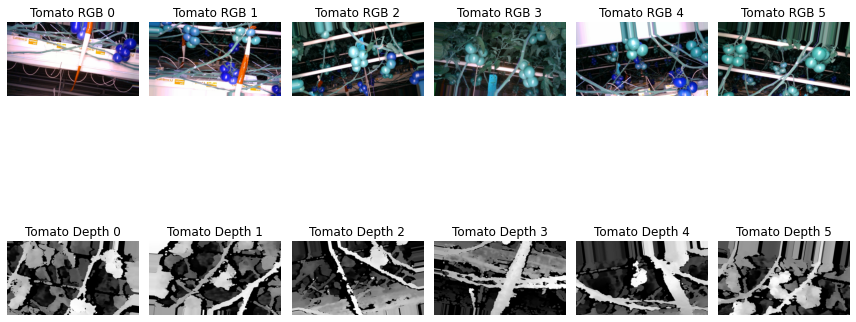

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 6, figsize=(12, 8))
for i in range(6):
    axs[0, i].imshow(aug_tomato_rgb_images[i])
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Tomato RGB {i}")
    axs[1, i].imshow(aug_tomato_depth_images[i], cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Tomato Depth {i}")
plt.tight_layout()
plt.show()


In [ ]:
len(aug_tomato_rgb_images)

75

In [ ]:
# Prepare the dataset for training
def prepare_dataset(img_paths, depth_paths, load_func, augment_func=None):
    # Create a rgbd_dataset from the images
    rgbd_dataset = tf.data.Dataset.from_tensor_slices((img_paths, depth_paths))
    rgbd_dataset = rgbd_dataset.map(
        lambda x, y: tf.py_function(load_func, [x, y], [tf.uint8, tf.uint16]))
    if augment_func is not None:
        rgbd_dataset = rgbd_dataset.map(augment_func)
    rgbd_dataset = rgbd_dataset.batch(32)
    return rgbd_dataset


# Prepare the tomato dataset
tomato_dataset = prepare_dataset(tomato_img_paths, tomato_depth_paths,
                                 load_tomato_data, augment_tomato_data)

# Prepare the lettuce dataset
lettuce_dataset = prepare_dataset(lettuce_img_paths, lettuce_depth_paths,
                                  load_lettuce_data)

# Combine the tomato and lettuce datasets
dataset = tf.data.Dataset.zip((tomato_dataset, lettuce_dataset))

In [ ]:
# Create the model using Fast RCNN and Panoptic Segmentation

# Load the RGB-D image dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.load_data()

# Normalize the images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the images to add the depth dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Build the base network for feature extraction
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base network
base_model.trainable = False

# Add additional layers for crop type prediction
crop_type_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the crop type model
crop_type_model.compile(optimizer='adam', loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Train the crop type model
crop_type_model.fit(x_train, y_train, epochs=5)

# Evaluate the crop type model on the test data
test_loss, test_acc = crop_type_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Use the crop type model to make predictions on new data
predictions = crop_type_model.predict(x_test)

In [ ]:
# Add additional layers for color prediction
color_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the color model
color_model.compile(optimizer='adam', loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train the color model
color_model.fit(x_train, y_train, epochs=5)

# Evaluate the color model on the test data
test_loss, test_acc = color_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Use the color model to make predictions on new data
predictions = color_model.predict(x_test)

In [ ]:
# Add additional layers for width and height prediction
wh_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2, activation='linear')
])

# Compile the width and height model

wh_model.compile(optimizer='adam', loss='mean_squared_error',
                 metrics=['accuracy'])

# Train the width and height model

wh_model.fit(x_train, y_train, epochs=5)

# Evaluate the width and height model on the test data

test_loss, test_acc = wh_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Use the width and height model to make predictions on new data

predictions = wh_model.predict(x_test)

In [ ]:
# Add additional layers for species prediction

species_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(number_of_species_classes,
                          activation='softmax')
])

# Compile the species model

species_model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the species model

species_model.fit(x_train, y_train, epochs=5)

# Evaluate the species model on the test data

test_loss, test_acc = species_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Use the species model to make predictions on new data

predictions = species_model.predict(x_test)

# Combine all the models for panoptic segmentation
panoptic_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2 + 3 + 2 + number_of_species_classes,
                          activation='softmax')
])

# Compile the panoptic model

panoptic_model.compile(optimizer='adam', loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the panoptic model

panoptic_model.fit(x_train, y_train, epochs=5)

# Evaluate the panoptic model on the test data

test_loss, test_acc = panoptic_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Use the panoptic model to make predictions on new data

predictions = panoptic_model.predict(x_test)